<a href="https://colab.research.google.com/github/pedroescobedob/DS-Unit-2-Applied-Modeling/blob/master/Pedro_Escobedo_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [117]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from ipywidgets import interact, fixed
from xgboost import XGBRegressor, XGBClassifier
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance
import shap

Using TensorFlow backend.


In [83]:
train.tail(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
51906,1953386,BIG SHARKS,NaN,2438115.0,Grocery Store,Risk 2 (Medium),2424 E 75TH ST,CHICAGO,IL,60649.0,2016-08-29T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.759110,-87.565383,"{'longitude': '-87.56538341238438', 'latitude'...",0
51907,1285813,JIMMY JOHNS,JIMMY JOHNS,2167555.0,Restaurant,Risk 1 (High),3234 W FOSTER AVE,CHICAGO,IL,60625.0,2012-10-11T00:00:00,Short Form Complaint,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.975840,-87.710115,"{'longitude': '-87.71011548431616', 'latitude'...",0
51908,1138647,STARBUCKS COFFEE,STARBUCKS,2142220.0,Restaurant,Risk 1 (High),1003-1005 N RUSH ST,CHICAGO,IL,60611.0,2012-11-27T00:00:00,License,NaN,41.900887,-87.627416,"{'longitude': '-87.62741623392772', 'latitude'...",0
51909,1609958,WHOLE FOODS,WHOLE FOODS,1678035.0,Grocery Store,Risk 1 (High),6020 N CICERO AVE,CHICAGO,IL,60646.0,2016-01-21T00:00:00,Canvass,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.990495,-87.748477,"{'longitude': '-87.74847741422931', 'latitude'...",1
51910,1474200,LITTLE ANGELS ACADEMY & KINDERGARTEN,LITTLE ANGELS ACADEMY & KINDERGARTEN,2215993.0,Daycare (2 - 6 Years),Risk 1 (High),10501 S TORRENCE AVE,CHICAGO,IL,60617.0,2014-06-30T00:00:00,License Re-Inspection,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.704495,-87.559481,"{'longitude': '-87.5594812461338', 'latitude':...",0
51911,1370030,VANILLE PATTISSERIE,VANILLE PATTISSERIE,2129404.0,Grocery Store,Risk 2 (Medium),131 N CLINTON ST,CHICAGO,IL,60661.0,2013-10-29T00:00:00,Canvass,NaN,41.884188,-87.641120,"{'longitude': '-87.64111966683218', 'latitude'...",0
51912,579387,CHICAGO STEAK HOUSE,CHICAGO STEAK HOUSE,2079910.0,Restaurant,Risk 2 (Medium),219 E 47TH ST,CHICAGO,IL,60653.0,2011-02-25T00:00:00,License Re-Inspection,NaN,41.809214,-87.620308,"{'longitude': '-87.62030817634384', 'latitude'...",0
51913,2169678,JEWEL FOOD STORE #3043,JEWEL FOOD STORE #3043,1144384.0,Grocery Store,Risk 1 (High),443 E 34TH ST,CHICAGO,IL,60616.0,2018-05-14T00:00:00,Canvass Re-Inspection,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.833045,-87.614611,"{'longitude': '-87.61461136443168', 'latitude'...",0
51914,1588969,RESTAURANTE SALVADORENO OLOCUILTA INC.,RESTAURANTE SALVADORENO OLOCUILTA,2308079.0,Restaurant,Risk 1 (High),3040 N LARAMIE AVE,CHICAGO,IL,60641.0,2015-11-30T00:00:00,Canvass Re-Inspection,NaN,41.936300,-87.756750,"{'longitude': '-87.75674980489909', 'latitude'...",0
51915,114560,BURRITO BEACH # 8,BURRITO BEACH,1491413.0,Restaurant,Risk 1 (High),200 E OHIO ST,CHICAGO,IL,60611.0,2010-09-29T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.892671,-87.622572,"{'longitude': '-87.62257220248128', 'latitude'...",0


In [0]:
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Fail'], random_state=42)

In [0]:
def wrangle(X):
  
  X = X.copy()

  # Remove unnecessary time for 'Inspection Date'
  X['Inspection Date'] = X['Inspection Date'].replace('T00:00:00', '')
  
  # Convert 'Inspection Date' to datetime
  X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)
  X['Year'] = X['Inspection Date'].dt.year
  X['Month'] = X['Inspection Date'].dt.month
  X = X.drop(columns='Inspection Date')
  
  # Drop unnecessary columns
  X = X.drop(columns=['Location','Inspection ID', 'DBA Name', 'AKA Name', 
                'License #', 'State', 'City','Address', 'Zip',
             'Violations'], axis=1)
     
  # Return wrangled dataframe
  return X

train = wrangle(train)
test = wrangle(test)
val = wrangle(val)

In [105]:
train.head()

,Facility Type,Risk,Inspection Type,Latitude,Longitude,Fail,Year,Month
13409,Restaurant,Risk 1 (High),Canvass,41.948869,-87.712340,0,2010,8
42587,Grocery Store,Risk 2 (Medium),License Re-Inspection,41.743870,-87.653705,1,2018,4
228,Restaurant,Risk 1 (High),Canvass,41.964740,-87.708504,0,2017,9
40468,Restaurant,Risk 2 (Medium),Complaint Re-Inspection,41.893513,-87.667363,0,2013,1
37472,Restaurant,Risk 1 (High),Canvass,41.887415,-87.624698,0,2014,11


In [106]:
fail = train.groupby('Month')['Fail'].value_counts()
fail

Month  Fail
1      0       2597
       1        897
2      0       2349
       1        855
3      0       2911
       1        956
4      0       2677
       1        898
5      0       2974
       1        964
6      0       2872
       1        981
7      0       2093
       1        816
8      0       2453
       1        978
9      0       2705
       1        987
10     0       2674
       1        965
11     0       2366
       1        764
12     0       2120
       1        680
Name: Fail, dtype: int64

In [107]:
# Feature Engineering, Facility Type
frequencies = train['Facility Type'].value_counts()
condition = frequencies <= 10
mask = frequencies[condition].index
mask_dict = dict.fromkeys(mask, 'other')
train['Facility Type'] = train['Facility Type'].replace(mask_dict)
train['Facility Type'].value_counts()

Restaurant                         27449
Grocery Store                       5481
School                              3079
Bakery                               680
Daycare (2 - 6 Years)                671
other                                637
Children's Services Facility         630
Daycare Above and Under 2 Years      543
Long Term Care                       320
Catering                             231
Mobile Food Dispenser                229
Liquor                               219
Daycare Combo 1586                   184
Wholesale                            158
Mobile Food Preparer                 135
Golden Diner                         124
Hospital                             113
TAVERN                                71
Shared Kitchen User (Long Term)       59
Daycare (Under 2 Years)               58
Special Event                         48
KIOSK                                 28
GAS STATION                           28
Shelter                               23
BANQUET HALL    

In [108]:
# Engineering Feature, Inspection Type
frequencies = train['Inspection Type'].value_counts()
condition = frequencies <= 10
mask = frequencies[condition].index
mask_dict = dict.fromkeys(mask, 'other')
train['Inspection Type'] = train['Inspection Type'].replace(mask_dict)
train['Inspection Type'].value_counts()

Canvass                                   19356
License                                    6301
Canvass Re-Inspection                      5017
Complaint                                  3935
License Re-Inspection                      2429
Complaint Re-Inspection                    1795
Short Form Complaint                       1674
License-Task Force                          168
Suspected Food Poisoning                    164
Consultation                                151
Tag Removal                                 115
Out of Business                              86
Task Force Liquor 1475                       73
Recent Inspection                            58
Suspected Food Poisoning Re-inspection       50
other                                        42
Complaint-Fire                               40
Short Form Fire-Complaint                    31
Special Events (Festivals)                   18
No Entry                                     17
Complaint-Fire Re-inspection            

In [110]:
train.head()

,Facility Type,Risk,Inspection Type,Latitude,Longitude,Fail,Year,Month
13409,Restaurant,Risk 1 (High),Canvass,41.948869,-87.712340,0,2010,8
42587,Grocery Store,Risk 2 (Medium),License Re-Inspection,41.743870,-87.653705,1,2018,4
228,Restaurant,Risk 1 (High),Canvass,41.964740,-87.708504,0,2017,9
40468,Restaurant,Risk 2 (Medium),Complaint Re-Inspection,41.893513,-87.667363,0,2013,1
37472,Restaurant,Risk 1 (High),Canvass,41.887415,-87.624698,0,2014,11


## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
# Target
target = 'Fail'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [119]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((41532, 7), (41532,), (10384, 7), (10384,), (17306, 7), (17306,))

In [115]:
# Random Forest with Ordinal Encoder
random_forest = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

random_forest.fit(X_train, y_train)
print('Validation Accuracy:', random_forest.score(X_val, y_val), 
      '\nTest Accuracy:', random_forest.score(X_test, y_test))

Validation Accuracy: 0.7449922958397535 
Test Accuracy: 0.7509534265572634


In [118]:
# Using eli5 to find permutation importances

# transforming data for permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

# setting model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# setting permuter to permutation importance
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=3,
    random_state=42
)

# fitting the data
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0552 ± 0.0037,Inspection Type
0.0313 ± 0.0058,Year
0.0099 ± 0.0048,Latitude
0.0082 ± 0.0013,Facility Type
0.0080 ± 0.0026,Longitude
0.0062 ± 0.0031,Month
0.0006 ± 0.0013,Risk


In [120]:
# ROC Score

y_pred_proba = random_forest.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.7067150126875652

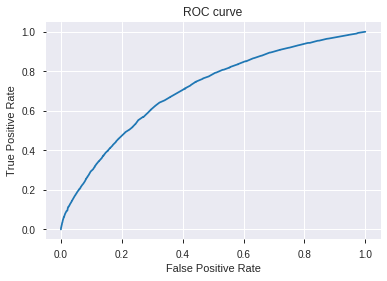

In [123]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val==1, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [125]:
# XGBoost
xgboost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

xgboost.fit(X_train, y_train)
print('Validation Accuracy:', xgboost.score(X_val, y_val), 
      '\nTest Accuracy:', xgboost.score(X_test, y_test))

Validation Accuracy: 0.7514445300462249 
Test Accuracy: 0.7532069802380678


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [0]:
# Features and labels for exploratory data analysis

y = train[target]
train_copy = train.copy()
train_copy['Fail'] = y

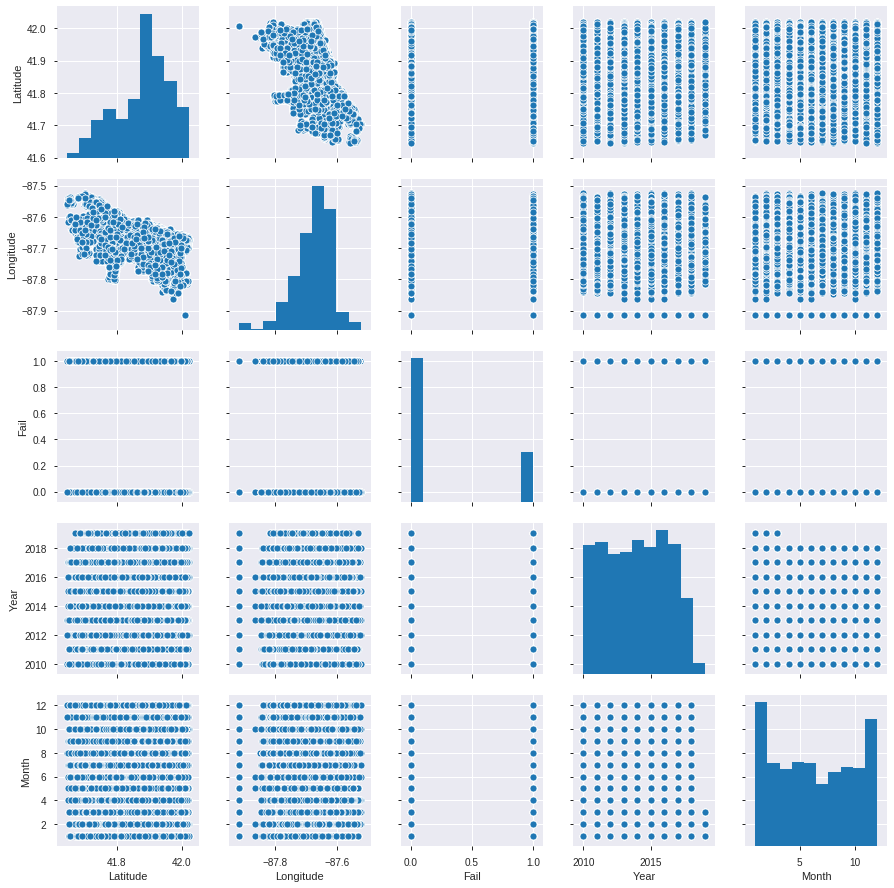

In [127]:
# Pairplot 

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(train_copy)
plt.show()

In [128]:
target = 'Fail'
features = train.columns.drop([target])

X = train[features]
y = train[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


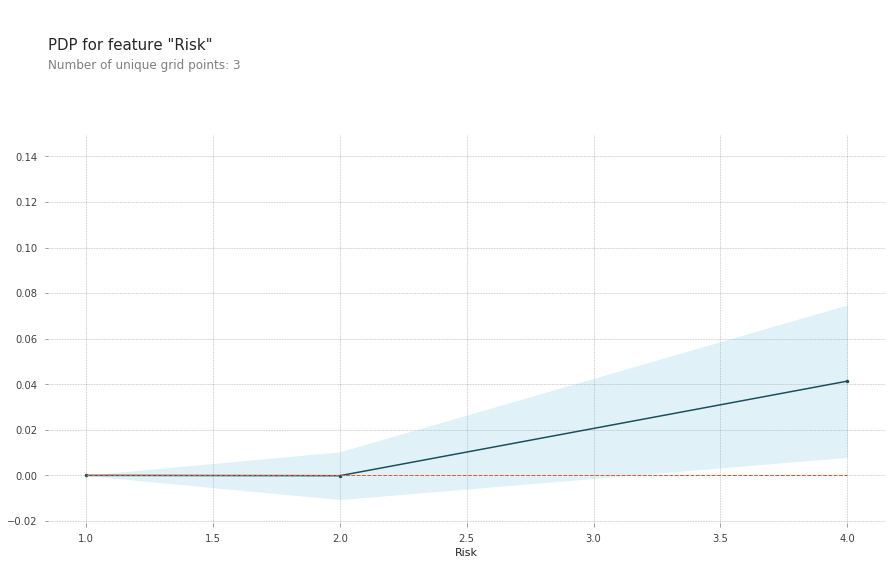

In [129]:
from pdpbox import pdp

feature = 'Risk'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [130]:
# Now use PDP for two features
train.columns

Index(['Facility Type', 'Risk', 'Inspection Type', 'Latitude', 'Longitude',
       'Fail', 'Year', 'Month'],
      dtype='object')

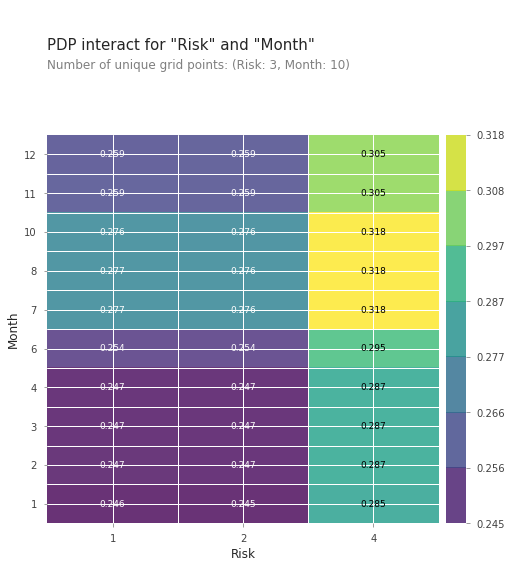

In [133]:
features = ['Risk', 'Month']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


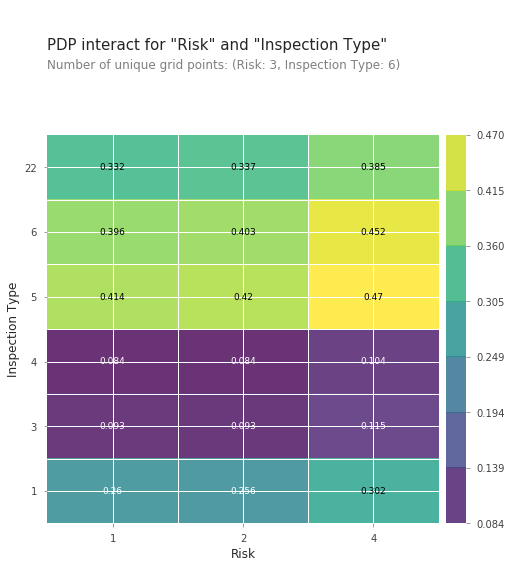

In [132]:
features = ['Risk', 'Inspection Type']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

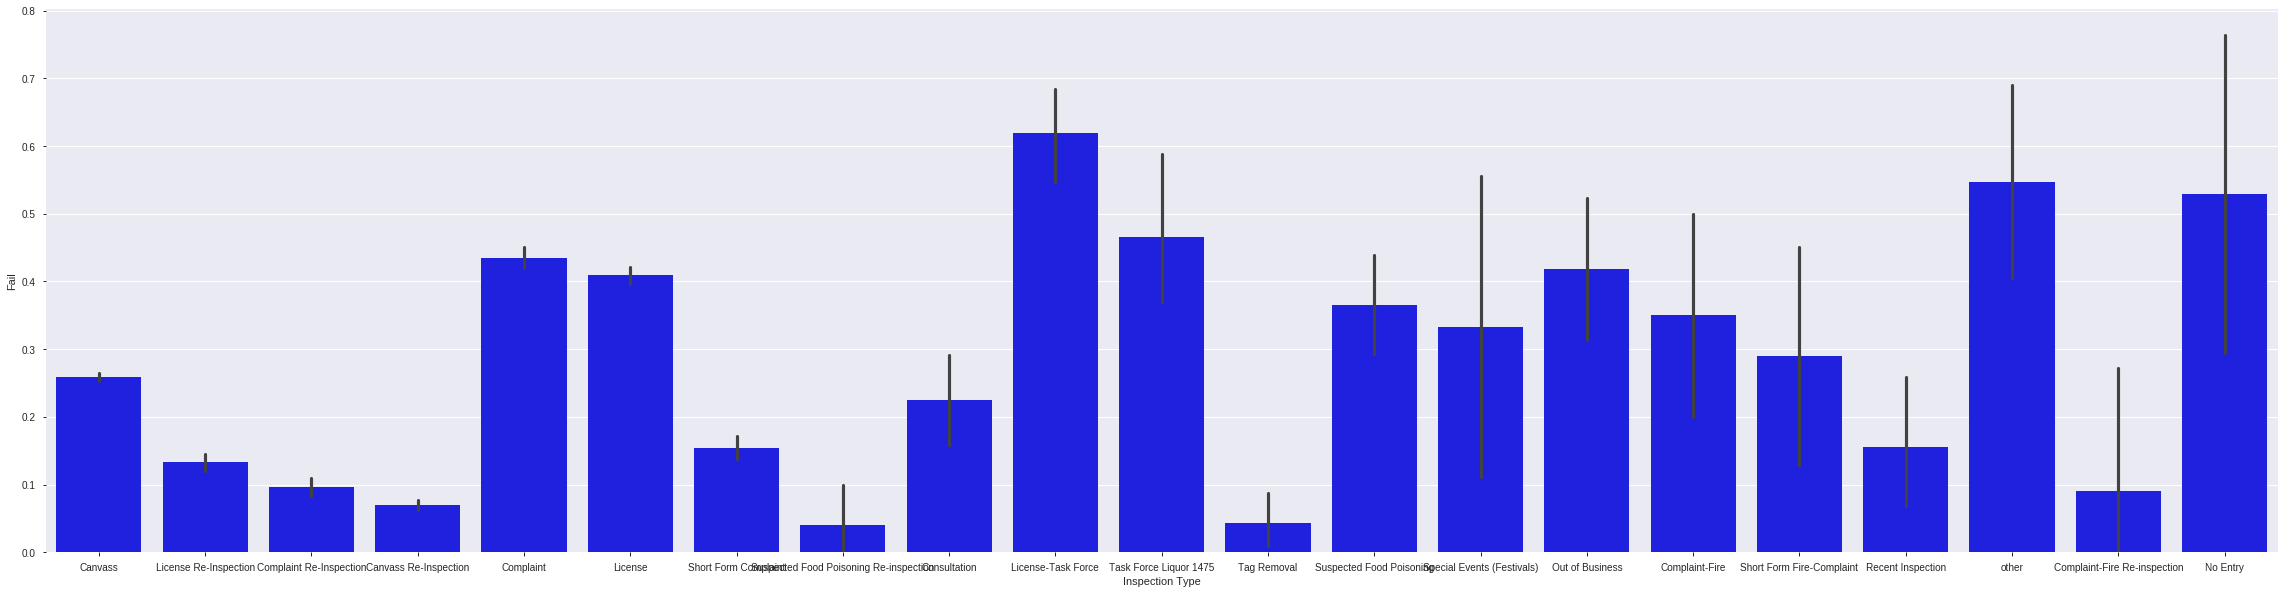

In [152]:
# Barchart
plt.figure(figsize=(40,10))
sns.barplot(x='Inspection Type', y='Fail', data=train_copy, color='b')

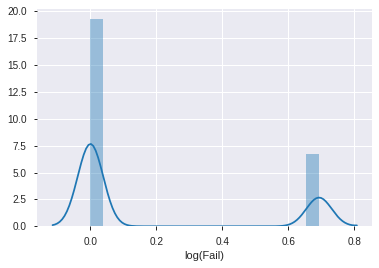

In [146]:
# log transform the target
import numpy as np

y = train_copy['Fail']
y_log = np.log1p(y)
train_copy['log(Fail)'] = y_log

# plot distribution of log-transformed target
sns.distplot(train_copy['log(Fail)']);

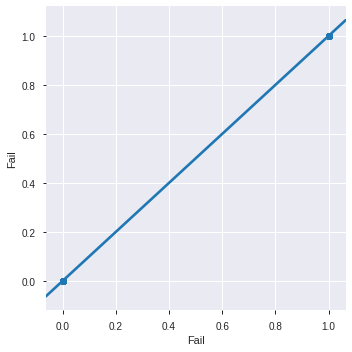

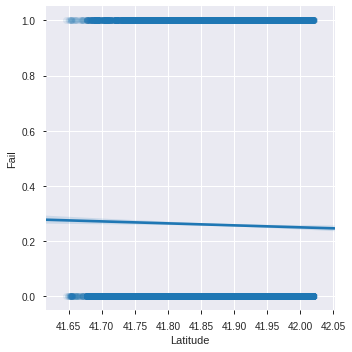

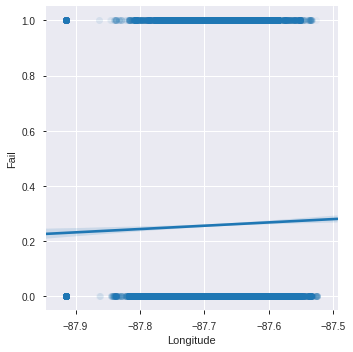

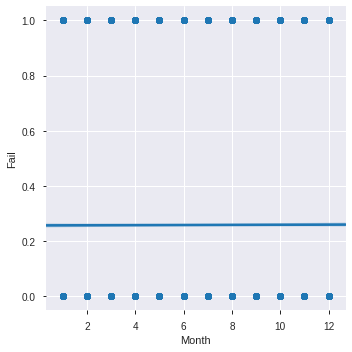

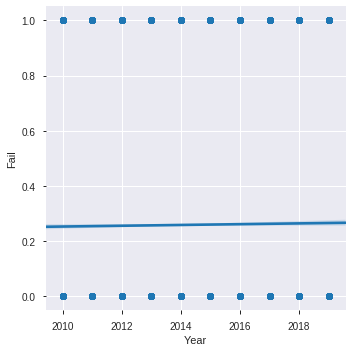

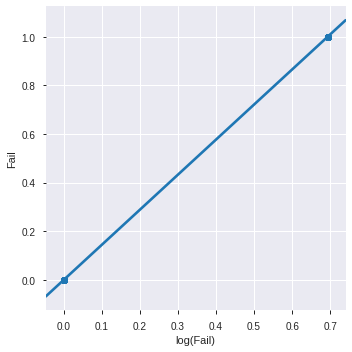

In [147]:
# Scatter plot
numeric = train_copy.select_dtypes('number')
for col in sorted(numeric.columns):
  sns.lmplot(x=col, y='Fail', data=train_copy, scatter_kws=dict(alpha=0.05))
  plt.show();